# IndicBert Hate Speech Detection

This notebook demonstrates hate speech detection using IndicBERT on the provided dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW, get_linear_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')

# For contrastive learning
from torch.nn.functional import cosine_similarity
from tqdm import tqdm
import random

## 2. Load and Explore Dataset
Load the provided dataset and visualize the class distribution.

In [3]:
# Load dataset
DATA_PATH = 'Data Exploration/Final_Dataset'
df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=['Comment', 'Annotation'])
df = df.reset_index(drop=True)
df

,Comment,Annotation
0,"Dekho dalit log, reservation ke naam pe kitna ...",Hatespeech
1,"Hal hi me Gujrat me Dalit dolha ko mara gaya"" ...",Not Hatespeech
2,Yeh baat ne peesha mera canada mein bhi nhi sh...,Hatespeech
3,Ye to galat hua aapke sath ...😤😤😤😤,Not Hatespeech
4,O pagal uncle aunty jin baba saheb ke bare me...,Not Hatespeech
...,...,...
7359,"kya din aagaya today bhim army, next thakur ar...",Not Hatespeech
7360,All Indian will become salve again soon in 2025,Not Hatespeech
7361,Upper caste waale toh bas dalit logon ko neech...,Hatespeech
7362,Dalit bahut hindu banta hai 😂😂 obc bhi hindu b...,Not Hatespeech


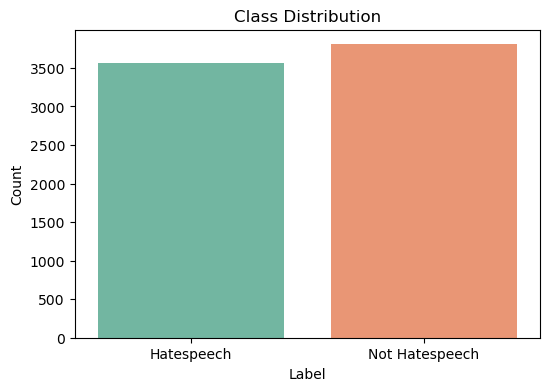

In [9]:
# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Annotation', data=df, palette='Set2')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## 3. Data Preprocessing and Visualization
Clean the text, encode labels, handle missing values, and visualize text length distributions.

Label mapping: {'Hatespeech': 0, 'Not Hatespeech': 1}


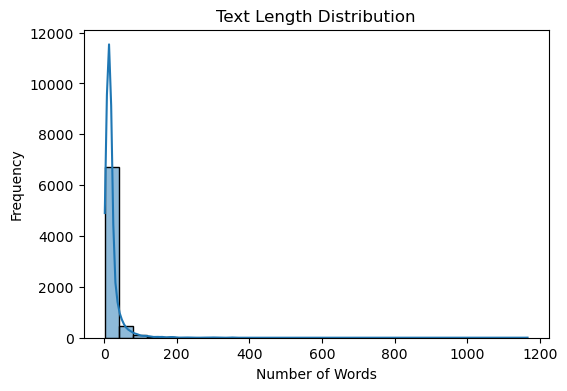

In [10]:
# Clean text (basic)
def clean_text(text):
    text = str(text).strip()
    return text

df['Comment'] = df['Comment'].apply(clean_text)

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['Annotation'])
print('Label mapping:', dict(zip(le.classes_, le.transform(le.classes_))))

# Visualize text length
df['text_len'] = df['Comment'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6,4))
sns.histplot(df['text_len'], bins=30, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [11]:
max_words = df['Comment'].apply(lambda x: len(str(x).split())).max()
print("Maximum number of words in any comment:", max_words)
# Remove outlier comments with more than 400 words
df = df[df['text_len'] <= 400]

Maximum number of words in any comment: 1166


## 4. Train-Test Split
Split the dataset into training and test sets, and visualize label distribution in each split.

Train size: 5890, Test size: 1473


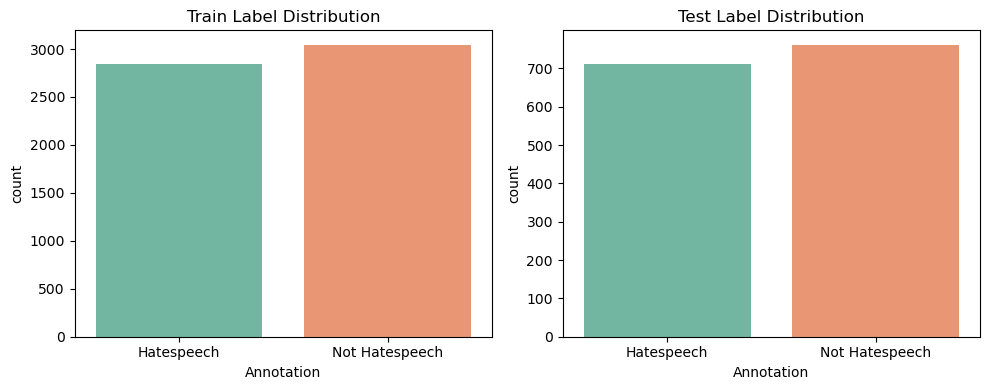

In [12]:
# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print(f'Train size: {len(train_df)}, Test size: {len(test_df)}')

fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x='Annotation', data=train_df, ax=ax[0], palette='Set2')
ax[0].set_title('Train Label Distribution')
sns.countplot(x='Annotation', data=test_df, ax=ax[1], palette='Set2')
ax[1].set_title('Test Label Distribution')
plt.tight_layout()
plt.show()

In [15]:
#check class distribution in train set
train_df["Annotation"].value_counts()

Annotation
Not Hatespeech    3043
Hatespeech        2847
Name: count, dtype: int64

In [14]:
#check class distribution in test set
test_df["Annotation"].value_counts()

Annotation
Not Hatespeech    761
Hatespeech        712
Name: count, dtype: int64

In [7]:
MAX_LEN = 400

# Convert data to PyTorch Dataset
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [8]:
# Define Transformer classifier
class TransformerClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs[1] if len(outputs) > 1 else outputs[0][:,0]
        return self.out(self.drop(pooled))

# Training loop (standard)
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler=None):
    model.train()
    losses, correct = [], 0
    for batch in tqdm(data_loader, desc='Training'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        _, preds = torch.max(outputs, dim=1)
        correct += torch.sum(preds == labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if scheduler: scheduler.step()
        optimizer.zero_grad()
    return np.mean(losses), correct.double() / len(data_loader.dataset)

def eval_epoch(model, data_loader, loss_fn, device):
    model.eval()
    losses, correct = [], 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs, dim=1)
            correct += torch.sum(preds == labels)
            losses.append(loss.item())
    return np.mean(losses), correct.double() / len(data_loader.dataset)

## Build and Train IndicBERT Model
Define and fine-tune IndicBERT for classification using standard cross-entropy loss. Plot training/validation loss and accuracy curves.

### Tokenization with IndicBERT
Use IndicBERT tokenizer to tokenize the text data and prepare input tensors for the model.

In [9]:
# Load IndicBERT tokenizer
MODEL_NAME = 'ai4bharat/indic-bert'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Prepare DataLoaders
train_dataset = HateSpeechDataset(train_df['Comment'].tolist(), train_df['label'].tolist(), tokenizer, MAX_LEN)
test_dataset = HateSpeechDataset(test_df['Comment'].tolist(), test_df['label'].tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Epoch 1/3


Training: 100%|██████████| 369/369 [34:47<00:00,  5.66s/it]


Train Loss: 0.5026, Val Loss: 0.4371, Train Acc: 0.7465, Val Acc: 0.7875
Epoch 2/3


Training: 100%|██████████| 369/369 [50:11<00:00,  8.16s/it]


Train Loss: 0.4254, Val Loss: 0.4261, Train Acc: 0.7902, Val Acc: 0.7848
Epoch 3/3


Training: 100%|██████████| 369/369 [1:10:29<00:00, 11.46s/it]


Train Loss: 0.3954, Val Loss: 0.4113, Train Acc: 0.7980, Val Acc: 0.7868


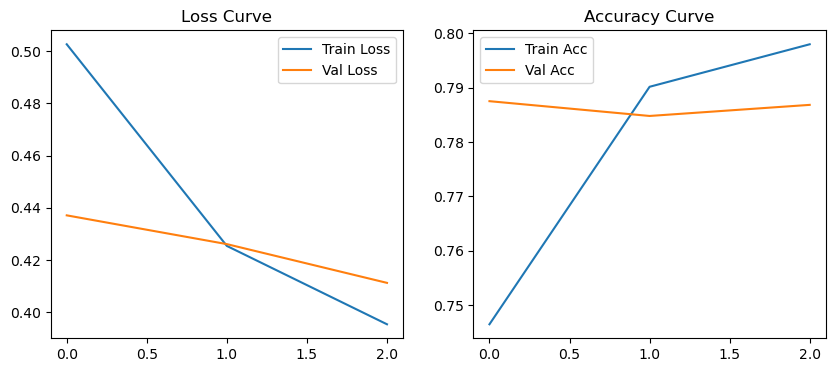

In [10]:
# Model setup
NUM_LABELS = len(le.classes_)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerClassifier(MODEL_NAME, NUM_LABELS).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*3)

# Training
EPOCHS = 3
train_losses, val_losses, train_accs, val_accs = [], [], [], []
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler)
    val_loss, val_acc = eval_epoch(model, test_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

# Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

## Evaluate Model Performance
Evaluate the model on the test set, show classification report, confusion matrix, and ROC curve.

In [11]:
# Evaluate on test set
def evaluate(model, data_loader, device):
    model.eval()
    predictions, true_labels, probs, embeddings, labels = [], [], [], [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['label']
            outputs = model(input_ids, attention_mask)
            bert_outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            softmaxed = torch.softmax(outputs, dim=1)
            preds = torch.argmax(softmaxed, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(label.to(device).cpu().numpy())
            probs.extend(softmaxed.cpu().numpy())
            emb = bert_outputs[1].cpu().numpy() if len(bert_outputs) > 1 else bert_outputs[0][:,0].cpu().numpy()
            embeddings.append(emb)
            labels.extend(label.cpu().numpy())
    return np.array(predictions), np.array(true_labels), np.array(probs), np.concatenate(embeddings), np.array(labels)

In [12]:
preds, trues, probs, emb_std, y_std = evaluate(model, test_loader, device)

Classification Report:
                precision    recall  f1-score   support

    Hatespeech       0.93      0.61      0.73       712
Not Hatespeech       0.72      0.96      0.82       761

      accuracy                           0.79      1473
     macro avg       0.82      0.78      0.78      1473
  weighted avg       0.82      0.79      0.78      1473



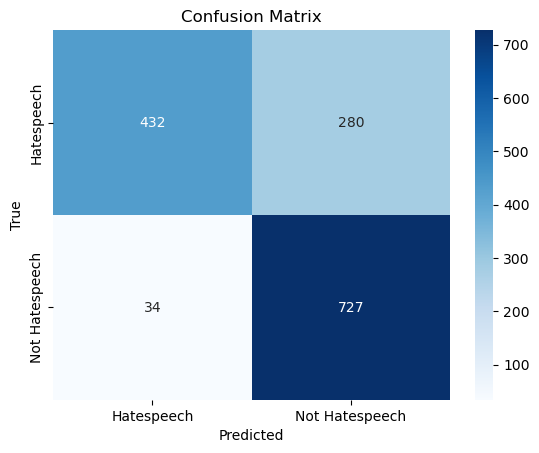

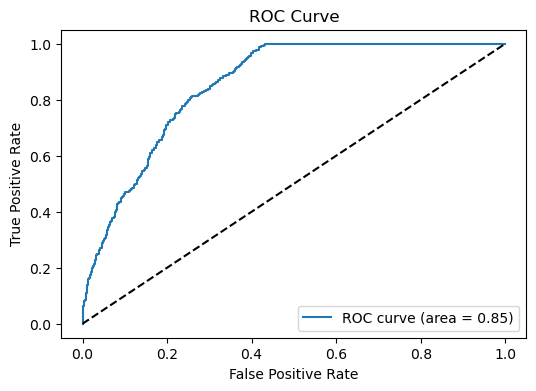

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


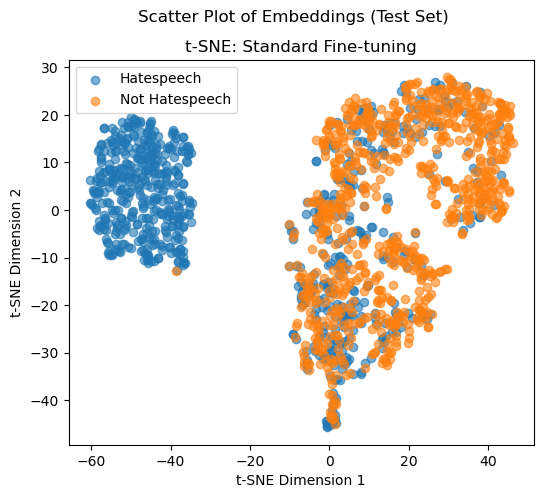

In [13]:
print('Classification Report:')
print(classification_report(trues, preds, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(trues, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(trues, probs[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
emb_std_2d = tsne.fit_transform(emb_std)

# Plot only for standard fine-tuning
plt.figure(figsize=(6,5))
for i, label in enumerate(le.classes_):
    plt.scatter(emb_std_2d[y_std==i,0], emb_std_2d[y_std==i,1], label=label, alpha=0.6)
plt.title('t-SNE: Standard Fine-tuning')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.suptitle('Scatter Plot of Embeddings (Test Set)')
plt.show()